In [222]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
plt.style.use('../fullwidth.mplstyle')
cmap = matplotlib.colormaps.get_cmap('tab10').colors
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h']
%matplotlib widget

# 1.4 - Calibration

[Text(0.5, 0, 'TDC channel'),
 Text(0, 0.5, 'Counts'),
 (200.0, 1000.0),
 (0.0, 3000.0)]

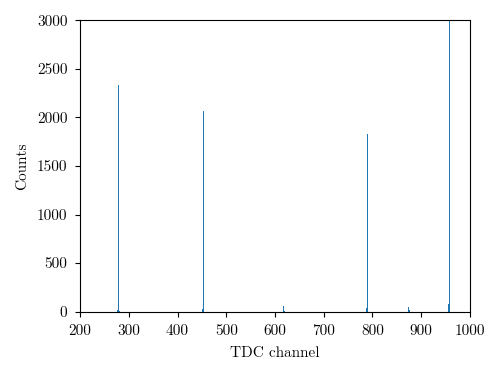

In [223]:
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
paths = [basepath + '_A_tdc_a.txt', basepath + '_B_tdc_b.txt', basepath + '_C_tdc_c.txt', basepath + '_D_tdc_d.txt']
fig,ax = plt.subplots()
data = np.loadtxt(paths[0])
ax.bar(data[:,0], data[:,1], width=1)
ax.set(xlabel='TDC channel', ylabel='Counts', xlim=(200, 1000), ylim=(0, 3000))

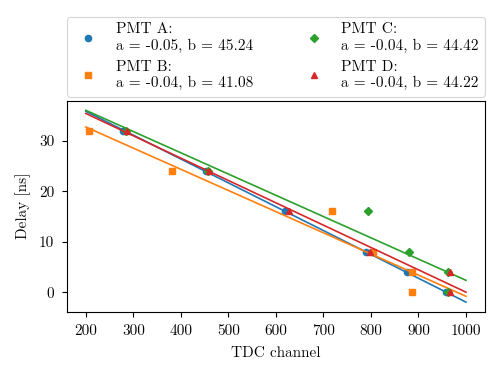

In [224]:
delays = [32,24,16,8,4,0] # ns; from left to right
fig,ax = plt.subplots()
lin = lambda x, a, b: a * x + b
time_calibration_values = []
for i,path in enumerate(paths):
    data = np.loadtxt(path)
    # get tdc channels of the 6 highest counts
    tdc = np.sort(np.argsort(data[:,1])[-6:]) + 1 # 0 based indexing
    popt, _ = curve_fit(lin, tdc, delays)
    time_calibration_values.append(popt)
    label = 'PMT ' + os.path.basename(path).split('_')[2] + ': \na = {:.2f}, b = {:.2f}'.format(popt[0], popt[1])
    ax.plot(tdc, delays, label=label, marker=markers[i], color=cmap[i], linestyle='None')
    ax.plot(np.linspace(200,1000,3), lin(np.linspace(200,1000,3), *popt), color=cmap[i])
    
ax.set(xlabel='TDC channel', ylabel='Delay [ns]')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=2, mode="expand", borderaxespad=0.)
time_calibration_values = np.array(time_calibration_values)
np.savetxt('time_calibration_values.txt', time_calibration_values, header='Time calibration values for PMT A-D. \nADC channel -> Time [ns] conversion: t = slope * ADC + yintersept\nRows correspond to PMT A-D\n\nslope \t\t\t\t y_intersept')

In [225]:
ecal = np.zeros((4,3))

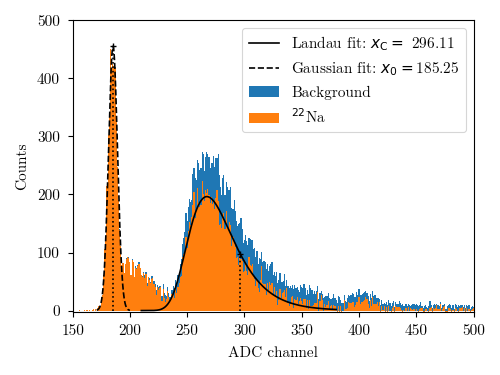

In [226]:
def moyal(x,a,b,c):
    return a * np.exp(-b*(x-c)) * np.exp(-np.exp(-b*(x-c)))  
def gauss(x, a, b, c):
    return a * np.exp(-0.5 * ((x - b) / c) ** 2)
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
paths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
data = np.loadtxt(paths[0])
cal = np.loadtxt(calpaths[0])

fig,ax = plt.subplots()
ax.bar(data[:,0], data[:,1], width=1, label='Background')
ax.bar(data[:,0], data[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, data[230:350,0], data[230:350,1] - cal[230:350,1], p0=(100, 0.01, 300), sigma=np.sqrt(np.abs(data[230:350,1] - cal[230:350,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(210, 380, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, data[150:200,0], data[150:200,1] - cal[150:200,1], p0=(400, 185, 10), bounds= [0, [500, 200, 100]], sigma=np.sqrt(np.abs(data[150:200,1] - cal[150:200,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(171, 200, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(150,500), ylim=(-2, 500))
ax.legend()

ecal[0,0] = fwhm
ecal[0,1] = popt[1]

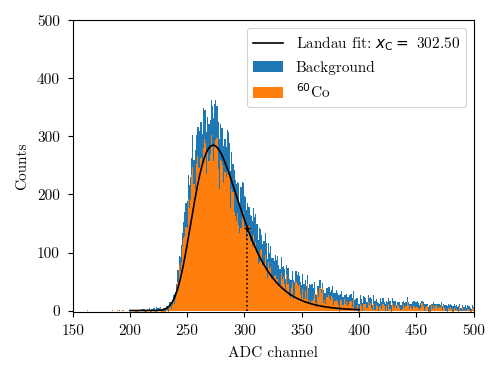

In [227]:
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
paths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
data = np.loadtxt(paths[0])
cal = np.loadtxt(calpaths[0])

fig,ax = plt.subplots()
ax.bar(data[:,0], data[:,1], width=1, label='Background')
ax.bar(data[:,0], data[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, data[200:400,0], data[200:400,1] - cal[200:400,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(data[200:400,1] - cal[200:400,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(200, 400, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(150,500), ylim=(-2, 500))
ax.legend()

ecal[0,2] = fwhm

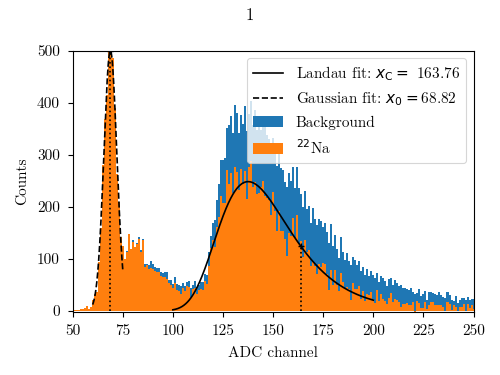

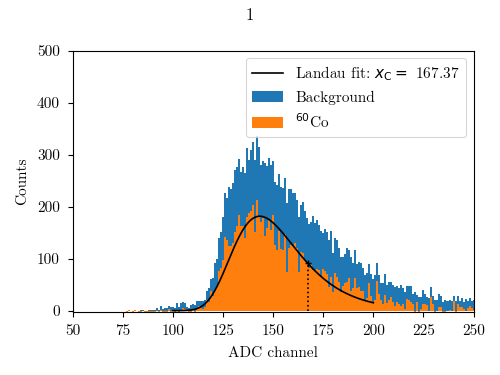

In [228]:
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
napaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
copaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
i = 1
co = np.loadtxt(copaths[i])
na = np.loadtxt(napaths[i])
cal = np.loadtxt(calpaths[i])
fig,ax = plt.subplots()
ax.bar(na[:,0], na[:,1], width=1, label='Background')
ax.bar(na[:,0], na[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, na[100:200,0], na[100:200,1] - cal[100:200,1], p0=(100, 0.01, 300), sigma=np.sqrt(np.abs(na[100:200,1] - cal[100:200,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(100, 200, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, na[60:75,0], na[60:75,1] - cal[60:75,1], p0=(400, 65, 10), bounds= [0, [500, 100, 10]], sigma=np.sqrt(np.abs(na[60:75,1] - cal[60:75,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(60, 75, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,250), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,0] = fwhm
ecal[i,1] = popt[1]

fig,ax = plt.subplots()
ax.bar(co[:,0], co[:,1], width=1, label='Background')
ax.bar(co[:,0], co[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, co[100:200,0], co[100:200,1] - cal[100:200,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(co[100:200,1] - cal[100:200,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(100, 200, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,250), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,2] = fwhm

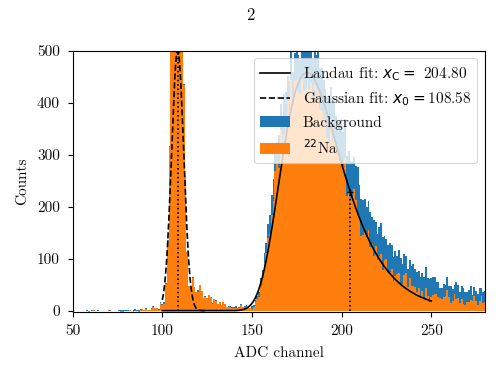

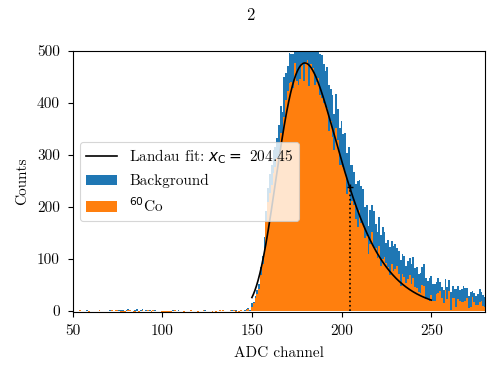

In [229]:
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
napaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
copaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
i = 2
co = np.loadtxt(copaths[i])
na = np.loadtxt(napaths[i])
cal = np.loadtxt(calpaths[i])
fig,ax = plt.subplots()
ax.bar(na[:,0], na[:,1], width=1, label='Background')
ax.bar(na[:,0], na[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, na[100:250,0], na[100:250,1] - cal[100:250,1], p0=(100, 0.01, 300), sigma=np.sqrt(np.abs(na[100:250,1] - cal[100:250,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(100, 250, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, na[100:125,0], na[100:125,1] - cal[100:125,1], p0=(400, 110, 10), bounds= [0, [500, 200, 10]], sigma=np.sqrt(np.abs(na[100:125,1] - cal[100:125,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(100, 125, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,280), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,0] = fwhm
ecal[i,1] = popt[1]

fig,ax = plt.subplots()
ax.bar(co[:,0], co[:,1], width=1, label='Background')
ax.bar(co[:,0], co[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, co[150:250,0], co[150:250,1] - cal[150:250,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(co[150:250,1] - cal[150:250,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(150, 250, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,280), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,2] = fwhm

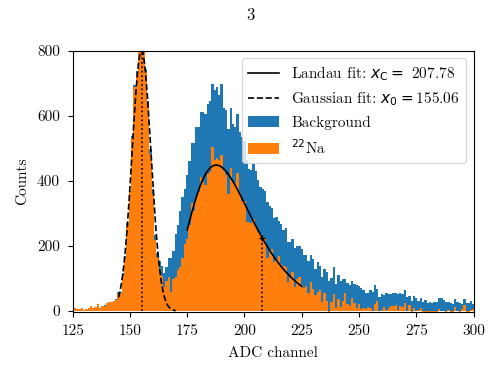

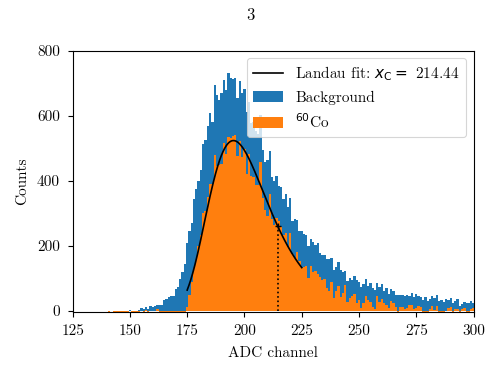

In [230]:
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
napaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
copaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
i = 3
co = np.loadtxt(copaths[i])
na = np.loadtxt(napaths[i])
cal = np.loadtxt(calpaths[i])
fig,ax = plt.subplots()
ax.bar(na[:,0], na[:,1], width=1, label='Background')
ax.bar(na[:,0], na[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, na[175:225,0], na[175:225,1] - cal[175:225,1], p0=(175, 0.01, 300), sigma=np.sqrt(np.abs(na[175:225,1] - cal[175:225,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(175, 225, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, na[145:170,0], na[145:170,1] - cal[145:170,1], p0=(600, 150, 10), bounds= [0, [800, 200, 10]], sigma=np.sqrt(np.abs(na[145:170,1] - cal[145:170,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(145, 170, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(125,300), ylim=(-2, 800))
ax.legend()
fig.suptitle(i)
ecal[i,0] = fwhm
ecal[i,1] = popt[1]

fig,ax = plt.subplots()
ax.bar(co[:,0], co[:,1], width=1, label='Background')
ax.bar(co[:,0], co[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, co[175:225,0], co[175:225,1] - cal[175:225,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(co[175:225,1] - cal[175:225,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(175, 225, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(125,300), ylim=(-2, 800))
ax.legend()
fig.suptitle(i)
ecal[i,2] = fwhm

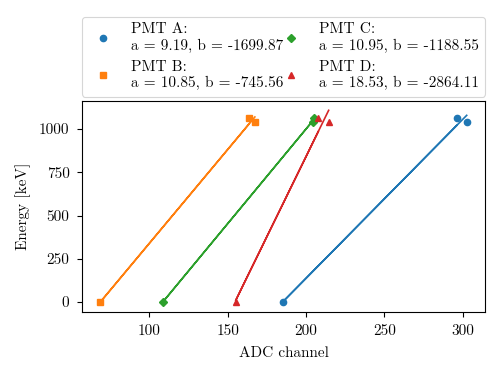

In [231]:
import comm


energies = np.array([1062.2, 0, (963.2+1117.62)/2]) # keV
lin = lambda x, a, b: a * x + b
energy_calibration_values = []
fig,ax = plt.subplots()
for i in range(4):
    adc = np.array([ecal[i,0], ecal[i,1], ecal[i,2]])
    popt, _ = curve_fit(lin, adc, energies)
    energy_calibration_values.append(popt)
    label = 'PMT ' +chr(65+i) + ': \na = {:.2f}, b = {:.2f}'.format(popt[0], popt[1])
    ax.plot(adc, lin(adc, *popt), color=cmap[i])
    ax.plot(adc, energies, label=label, marker=markers[i], color=cmap[i], linestyle='None')
ax.set( xlabel='ADC channel', ylabel='Energy [keV]')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=2, mode="expand", borderaxespad=0.)
energy_calibration_values = np.array(energy_calibration_values)
np.savetxt('energy_calibration_values.txt', energy_calibration_values, header='Energy calibration values for PMT A-D. \nADC channel -> Energy [keV] conversion: E = slope * ADC + yintersept\nRows correspond to PMT A-D\n\nslope \t\t\t\t y_intersept')

In [ ]:
time_calibration_values = np.loadtxt('time_calibration_values.txt')
energy_calibration_values = np.loadtxt('energy_calibration_values.txt')
def time_cal(tdc, which):
    if which == 'A':
        a, b = time_calibration_values[0]
    elif which == 'B':  
        a, b = time_calibration_values[1]
    elif which == 'C':
        a, b = time_calibration_values[2]
    elif which == 'D':
        a, b = time_calibration_values[3]
    return a * tdc + b
def energy_cal(adc, which):
    if which == 'A':
        a, b = energy_calibration_values[0]
    elif which == 'B':  
        a, b = energy_calibration_values[1]
    elif which == 'C':
        a, b = energy_calibration_values[2]
    elif which == 'D':
        a, b = energy_calibration_values[3]
    return a * adc + b

array([[    9.18811616, -1699.86724925],
       [   10.84946224,  -745.5593547 ],
       [   10.94596443, -1188.54727348],
       [   18.52627523, -2864.10613457]])